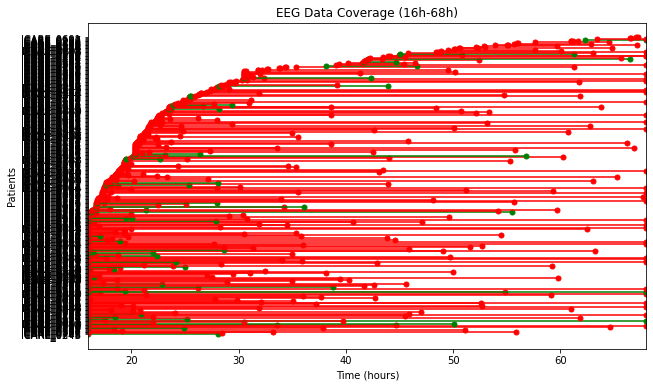

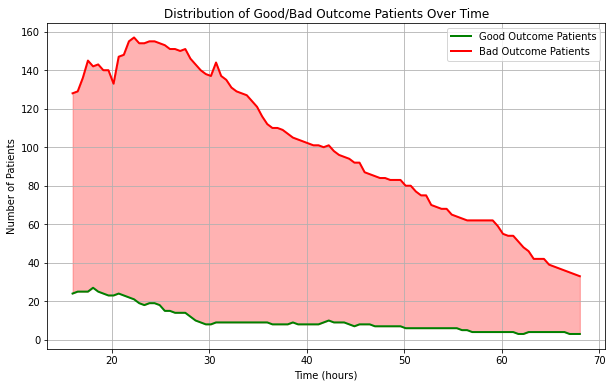

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 读取 SSD 文件（包含 ROSC 时间）
ssd_file = 'files_art_ssd_fts_predictions.csv'
ssd_df = pd.read_csv(ssd_file)

# 提取 `pat_ID` 和 `rosc_sec`
ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()  # 获取每个患者的最早 rosc_sec

# 设定时间窗口 (16h-68h)
WINDOW_START = 16 * 3600  # 16h 转换成秒
WINDOW_END = 68 * 3600  # 68h 转换成秒

# 设定数据路径
data_folder = "5min_smoothed_data/"
outcome_file = "valid_patients_outcome.csv"

# 读取 Good/Bad Outcome 数据
outcome_df = pd.read_csv(outcome_file)
outcome_dict = outcome_df.set_index('pat_ID')['outcome'].to_dict()

# 统计所有患者的数据时间信息
patient_time_info = []

for file in os.listdir(data_folder):
    if not file.endswith('.csv'):
        continue  # 只处理 CSV 文件
    
    patient_id = file.split('.')[0]
    if patient_id not in rosc_dict:
        continue  # 该患者没有 ROSC 时间，跳过
    
    # 获取 ROSC 时间
    rosc_sec = rosc_dict[patient_id]

    # 读取 EEG 文件，计算数据长度
    file_path = os.path.join(data_folder, file)
    eeg_data = pd.read_csv(file_path)  # 读取 EEG 数据
    num_timepoints = eeg_data.shape[0]  # 数据点数
    total_duration = num_timepoints * 300  # EEG 记录的总时长（秒）

    # 计算原始数据的起止时间
    raw_start_time = rosc_sec  # 原始数据开始时间
    raw_end_time = rosc_sec + total_duration  # 原始数据结束时间

    # 计算 16h-68h 内可用的时间段
    valid_start = max(raw_start_time, WINDOW_START)
    valid_end = min(raw_end_time, WINDOW_END)

    if valid_start < valid_end:  # 确保有交集
        patient_time_info.append({
            "Patient ID": patient_id,
            "Raw Start Time (hours)": raw_start_time / 3600,
            "Raw End Time (hours)": raw_end_time / 3600,
            "Valid Start Time (hours)": valid_start / 3600,
            "Valid End Time (hours)": valid_end / 3600,
            "Valid Duration (hours)": (valid_end - valid_start) / 3600,
            "Outcome": 1 if outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0
        })

# 转换为 DataFrame
df_time_info = pd.DataFrame(patient_time_info)

# 可视化 EEG 数据覆盖时间段
fig, ax = plt.subplots(figsize=(10, 6))

# 按 valid_start 排序
df_time_info = df_time_info.sort_values(by="Valid Start Time (hours)")

# 提取数据
patient_ids = df_time_info["Patient ID"]
valid_start_times = df_time_info["Valid Start Time (hours)"]
valid_end_times = df_time_info["Valid End Time (hours)"]
outcomes = df_time_info["Outcome"]

# 绘制数据覆盖时间范围条形图
for i, (start, end, outcome) in enumerate(zip(valid_start_times, valid_end_times, outcomes)):
    color = 'green' if outcome == 1 else 'red'  # Good Outcome = green, Bad Outcome = red
    ax.plot([start, end], [i, i], marker='o', linestyle='-', markersize=5, color=color)

# 设置坐标轴
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Patients")
ax.set_title("EEG Data Coverage (16h-68h)")
ax.set_xlim(16, 68)
ax.set_yticks(range(len(patient_ids)))
ax.set_yticklabels(patient_ids)

plt.show()

# 统计 good/bad outcome 在各个时间点的分布
time_intervals = np.linspace(16, 68, num=100)  # 100 个时间点
good_counts = np.zeros_like(time_intervals)
bad_counts = np.zeros_like(time_intervals)

for start, end, outcome in zip(valid_start_times, valid_end_times, outcomes):
    for i, t in enumerate(time_intervals):
        if start <= t <= end:
            if outcome == 1:
                good_counts[i] += 1
            else:
                bad_counts[i] += 1

# 绘制 good/bad outcome 分布
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_intervals, good_counts, label="Good Outcome Patients", color="green", linewidth=2)
ax.plot(time_intervals, bad_counts, label="Bad Outcome Patients", color="red", linewidth=2)
ax.fill_between(time_intervals, good_counts, bad_counts, where=(good_counts > bad_counts), color='green', alpha=0.3, interpolate=True)
ax.fill_between(time_intervals, good_counts, bad_counts, where=(bad_counts > good_counts), color='red', alpha=0.3, interpolate=True)

# 标注
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Number of Patients")
ax.set_title("Distribution of Good/Bad Outcome Patients Over Time")
ax.legend()
ax.grid(True)

plt.show()

# 选择 good/bad outcome 相对均衡的时间段
best_time_index = np.argmax(good_counts - bad_counts) 

In [27]:
import numpy as np
import pandas as pd

# 确保 df_time_info 存在
if 'df_time_info' not in locals():
    raise ValueError("请先计算 `df_time_info`，确保患者数据时间范围可用")

# 重新获取数据时间范围，并过滤 None 值
valid_start_times = df_time_info["Valid Start Time (hours)"].dropna().to_numpy()
valid_end_times = df_time_info["Valid End Time (hours)"].dropna().to_numpy()
valid_durations = df_time_info["Valid Duration (hours)"].dropna().to_numpy()

# 设定可接受的最小覆盖比例，例如 90%（可以调整）
coverage_threshold = 0.4

# 生成时间点范围（16h - 68h，步长 0.1h）
time_grid = np.arange(16, 68, 0.1)

# 统计每个时间点的覆盖患者数
coverage_counts = np.zeros_like(time_grid)

for start, end in zip(valid_start_times, valid_end_times):
    for i, t in enumerate(time_grid):
        if start <= t <= end:
            coverage_counts[i] += 1

# 计算总患者数
total_patients = len(valid_start_times)

# 计算覆盖比例
coverage_ratio = coverage_counts / total_patients

# 找到满足覆盖阈值的最大连续时间段
best_start, best_end = None, None
current_start = None

for i, t in enumerate(time_grid):
    if coverage_ratio[i] >= coverage_threshold:
        if current_start is None:
            current_start = t  # 记录新的起点
        best_end = t  # 更新终点
    else:
        if current_start is not None and (best_start is None or best_end - best_start < t - current_start):
            best_start, best_end = current_start, best_end
        current_start = None

# 确保最后一个段落被考虑
if current_start is not None and (best_start is None or best_end - best_start < best_end - current_start):
    best_start, best_end = current_start, best_end

# 如果找不到符合条件的时间段，直接退出
if best_start is None or best_end is None:
    raise ValueError("❌ 无法找到满足覆盖比例的时间段")

# 计算保留数据量
selected_data_count = np.sum([
    max(0, min(float(best_end), float(end)) - max(float(best_start), float(start)))
    for start, end in zip(valid_start_times, valid_end_times)
])

# 计算原始数据总量（所有患者的 EEG 记录时长总和）
original_total_data = np.sum(valid_durations)

# 计算丢失的数据量
data_reduction = original_total_data - selected_data_count
reduction_percentage = (data_reduction / original_total_data) * 100

# 输出结果
print(f"✅ 最佳覆盖 {coverage_threshold*100:.1f}% 的时间段：{best_start:.2f}h - {best_end:.2f}h，时长：{best_end - best_start:.2f} 小时")
print(f"📊 在该时间段内，保留的数据总量：{selected_data_count:.2f}")
print(f"⚠️ 丢失的数据量：{data_reduction:.2f}，占原始数据总量的 {reduction_percentage:.2f}%")

✅ 最佳覆盖 40.0% 的时间段：16.00h - 30.70h，时长：14.70 小时
📊 在该时间段内，保留的数据总量：2418.73
⚠️ 丢失的数据量：3275.83，占原始数据总量的 57.53%


In [13]:
import numpy as np

# 重新计算 Good/Bad Outcome 患者数量在各时间点的分布
time_intervals = np.linspace(16, 68, num=100)  # 100 个时间点
good_counts = np.zeros_like(time_intervals)
bad_counts = np.zeros_like(time_intervals)

for start, end, outcome in zip(valid_start_times, valid_end_times, outcomes):
    for i, t in enumerate(time_intervals):
        if start <= t <= end:
            if outcome == 1:
                good_counts[i] += 1
            else:
                bad_counts[i] += 1

# 计算 Good + Bad 总数
total_counts = good_counts + bad_counts

# 找到最大数据量的索引
peak_index = np.argmax(total_counts)
start_index = peak_index
end_index = peak_index

# 设定最小数据阈值（90%）
threshold = total_counts[peak_index] * 0.9

# 向左扩展，找到最早的时间点
while start_index > 0 and total_counts[start_index] >= threshold:
    start_index -= 1

# 向右扩展，找到最晚的时间点
while end_index < len(time_intervals) - 1 and total_counts[end_index] >= threshold:
    end_index += 1

# 获取最终的时间范围
start_time = time_intervals[start_index]
end_time = time_intervals[end_index]
duration = end_time - start_time

# 计算原始总数据量
original_total_data = np.sum(total_counts)

# 计算选定时间段内的数据量
selected_data_count = np.sum(total_counts[start_index:end_index])

# 计算减少的数据量
data_reduction = original_total_data - selected_data_count
reduction_percentage = (data_reduction / original_total_data) * 100

# 输出结果
print(f"最优时间段（最大覆盖，左右扩展）：{start_time:.2f}h - {end_time:.2f}h，时长：{duration:.2f} 小时")
print(f"在该时间段内，保留的数据总量：{selected_data_count}")
print(f"丢失的数据量：{data_reduction}，占原始数据总量的 {reduction_percentage:.2f}%")

最优时间段（最大覆盖，左右扩展）：20.20h - 28.08h，时长：7.88 小时
在该时间段内，保留的数据总量：2546.0
丢失的数据量：8388.0，占原始数据总量的 76.71%


In [11]:
import numpy as np

# 计算 Good + Bad 总数
total_counts = good_counts + bad_counts

# 找到最大数据量的起点
peak_index = np.argmax(total_counts)
start_time = time_intervals[peak_index]

# 从起点向右扩展，确保囊括最多数据
threshold = total_counts[peak_index] * 0.9  # 设定最小数据阈值（70%）
end_index = peak_index

while end_index < len(time_intervals) - 1 and total_counts[end_index] >= threshold:
    end_index += 1

end_time = time_intervals[end_index]

# 输出结果
print(f"最优时间段（最大覆盖）：{start_time:.2f}h - {end_time:.2f}h，时长：{end_time - start_time:.2f} 小时")

最优时间段（最大覆盖）：22.30h - 28.08h，时长：5.78 小时


In [12]:
import numpy as np

# 重新计算 Good + Bad 总数
total_counts = good_counts + bad_counts

# 确定选定时间段索引
start_index = np.where(time_intervals >= start_time)[0][0]
end_index = np.where(time_intervals >= end_time)[0][0]

# 计算原始总数据量
original_total_data = np.sum(total_counts)

# 计算选定时间段内的数据量
selected_data_count = np.sum(total_counts[start_index:end_index])

# 计算减少的数据量
data_reduction = original_total_data - selected_data_count

# 计算减少的比例
reduction_percentage = (data_reduction / original_total_data) * 100

# 输出结果
print(f"在时间段 {start_time:.2f}h - {end_time:.2f}h 内，保留的数据总量：{selected_data_count}")
print(f"丢失的数据量：{data_reduction}，占原始数据总量的 {reduction_percentage:.2f}%")

在时间段 22.30h - 28.08h 内，保留的数据总量：1871.0
丢失的数据量：9063.0，占原始数据总量的 82.89%
